In [18]:
library(tidyverse)
library(scales)

In [19]:
data_path <- '/cfs/earth/scratch/kraftjul/DaAn_Projektarbeit/data/aggregated_data'

In [20]:
files <- dir(data_path)

In [22]:
data_out <- tibble()

for (file in files) {
  # read csv and append data to list
  print(file)
  data <- read.csv(file.path(data_path, file), nrows = 100000) 
  data_out <- rbind(data_out, data)
}

[1] "2016_aggregated.csv"
[1] "2017_aggregated.csv"
[1] "2018_aggregated.csv"
[1] "2019_aggregated.csv"
[1] "2020_aggregated.csv"
[1] "2021_aggregated.csv"
[1] "2022_aggregated.csv"


In [23]:
data_out %>% write.csv("/cfs/earth/scratch/kraftjul/DaAn_Projektarbeit/test_data.csv")

In [9]:
data_analysis <- 
    data_out %>%
        mutate(
            betriebsdatum = dmy(betriebsdatum),
            year = year(betriebsdatum),
            year = as.factor(year),
            verspaetung_cat = 
                case_when(
                    verspaetung < -60 ~ -1,
                    verspaetung < 120 ~ 0,
                    verspaetung < 300 ~ 1,
                    TRUE ~ 2

                ),
            verspaetung_cat = as.factor(verspaetung_cat) %>% fct_rev()        )


In [10]:
alpha <- 0.05
result_bartlett <- bartlett.test(verspaetung ~ year, data = data_analysis)

if(result_bartlett$p.value < alpha) {
    print('Reject H0: Variances are not equal')
    print("Performing Welch's ANOVA")
    model <- oneway.test(verspaetung ~ year, data = data_analysis)
}else{
    print('Accept H0: Variances are equal')
    print("Performing ANOVA")
    model <- aov(verspaetung ~ year, data = data_analysis)
}
model

if(model$p.value < alpha) {
    print('Reject H0: There is a significant difference between the groups')
    print("Post Hoc test")

    with(data_analysis,
         pairwise.t.test(verspaetung, year))
}else{
    print('Accept H0: There is no significant difference between the groups')
}


[1] "Reject H0: Variances are not equal"
[1] "Performing Welch's ANOVA"



	One-way analysis of means (not assuming equal variances)

data:  verspaetung and year
F = 185939, num df = 6, denom df = 101246173, p-value < 2.2e-16


[1] "Reject H0: There is a significant difference between the groups"
[1] "Post Hoc test"



	Pairwise comparisons using t tests with pooled SD 

data:  verspaetung and year 

     2016    2017    2018    2019    2020    2021   
2017 < 2e-16 -       -       -       -       -      
2018 < 2e-16 < 2e-16 -       -       -       -      
2019 < 2e-16 < 2e-16 4.3e-11 -       -       -      
2020 < 2e-16 < 2e-16 < 2e-16 < 2e-16 -       -      
2021 < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 -      
2022 < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16

P value adjustment method: holm 

In [11]:
data_analysis %>%
    group_by(year) %>%
    summarise(
        mean = mean(verspaetung),
        median = median(verspaetung),
        sd = sd(verspaetung),
        n = n()
    ) 

year,mean,median,sd,n
<fct>,<dbl>,<dbl>,<dbl>,<int>
2016,23.87193,12,73.27740,32330887
2017,25.29071,12,83.61678,32164802
2018,24.93918,10,89.73184,33390389
2019,24.79336,9,100.56253,33441280
2020,10.29503,1,77.41079,32366998
2021,12.22689,1,105.89882,32973049
2022,16.86157,4,96.73881,31527256


In [17]:
data_analysis %>%
    count(year, verspaetung_cat) %>%
    group_by(year) %>%
    mutate(
        perc = round(n / sum(n)*100,2)
    ) %>%
    select(-n) %>%
    pivot_wider(names_from = year, values_from = perc)

verspaetung_cat,2016,2017,2018,2019,2020,2021,2022
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,0.59,0.74,0.85,1.00,0.41,0.68,0.79
1,5.73,6.17,6.62,6.86,3.86,4.14,5.15
0,91.66,91.02,90.22,89.76,92.17,91.53,90.74
-1,2.02,2.08,2.31,2.38,3.56,3.66,3.31


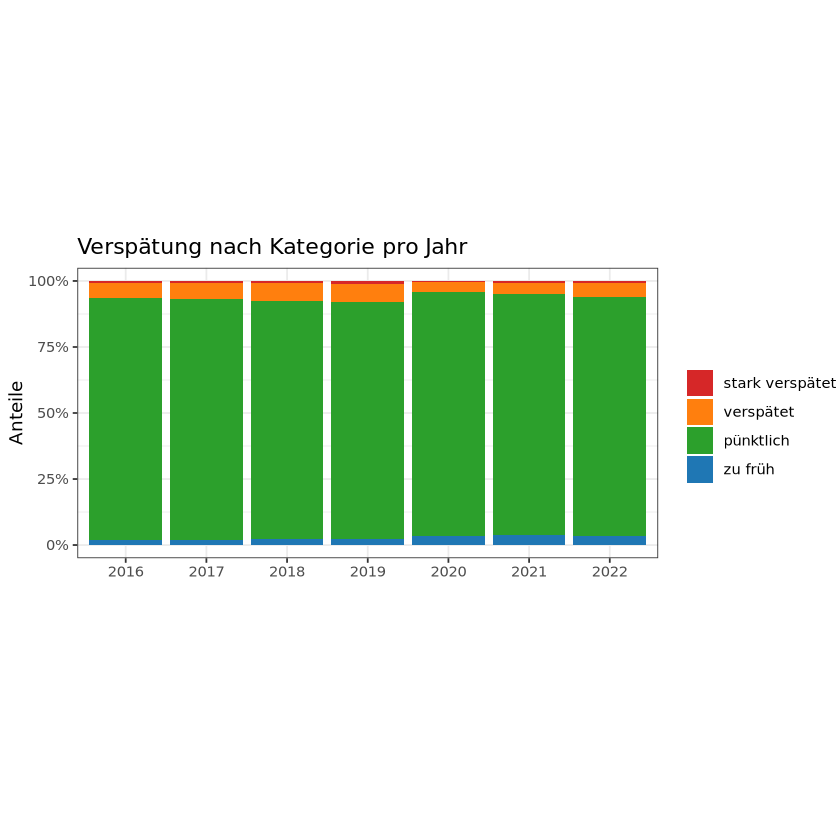

In [12]:
delay_colors <- c(
  "-1" = "#1f77b4",  # Too Early
  "0" = "#2ca02c",   # On Time
  "1" = "#ff7f0e",   # Late
  "2" = "#d62728"    # Very Late
)

data_analysis %>%
    ggplot(
        aes(
            x = year,
            fill = verspaetung_cat,
        )
    )+

    geom_bar(
        position = "fill"
    )+

    scale_y_continuous(
        labels = scales::percent_format()
    )+

    scale_fill_manual(
        name = "",
        values = delay_colors,
        labels = c("stark verspätet", "verspätet", "pünktlich", "zu früh")
    )+

    labs(
        title = "Verspätung nach Kategorie pro Jahr",
        x = "",
        y = "Anteile"
    )+

    theme_bw()+

    theme(
        aspect.ratio = 0.5
    )